In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform

import gym
import mazelab
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm
import imageio
from IPython.display import Image

from stable_baselines3 import A2C
sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

from captum.attr import (
    Saliency,
    IntegratedGradients,
    FeatureAblation,
    FeaturePermutation,
    Occlusion,
    ShapleyValueSampling    
)

In [2]:
########### Set Device ############
# device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device = 'cpu'
dtype = th.float32
th.set_default_dtype(dtype)
print(f"Using {device} device")

Using cpu device


In [3]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        w, h = env.observation_space.shape
        features = 2 * w * h
        self.net = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(features, 64, bias=True),
            nn.Tanh(),
            nn.Linear(64, 64, bias=True),
            nn.Tanh(),
            nn.Linear(64, 1, bias=False),
        ).to(device)
        self.device = device

    def forward(self, obs):
        return self.net(th.tensor(obs).to(self.device))
    
    def tforward(self, ss):
        return self.net(ss)

In [4]:
envs = [
    "EmptyMaze-10x10-FixedGoal-v3",
    "EmptyMaze-10x10-CoinFlipGoal-v3",
]

In [109]:
env_id = envs[0]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-FixedGoal-v3


In [110]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [111]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v2-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v2-rollout.gif", width=110, height=110)

In [112]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}_ss-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [115]:
N = 12

obs = env.reset()
next_obs = None
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    next_obs, reward, done, info = env.step(action)
    reward_input = np.array((obs, next_obs)).astype(np.float32)
    predicted_rewards.append(float(rm(np.expand_dims(reward_input, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
    else:
        obs = next_obs
print("Predicted: ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: +0.01 -0.00 +0.01 +0.00 +0.01 +0.01 +1.00 
True     : +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +1.00 


### Okay so this reward model appears to be working correctly

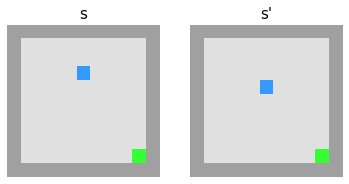

In [12]:
obs = env.reset()
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(action)
sp_img = env.maze.to_rgb()

plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_example.png', dpi=300, bbox_inches='tight')

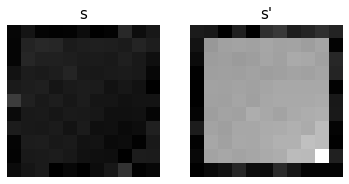

In [13]:
sal = Saliency(rm.tforward)

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = np.abs(sal.attribute(input))
vmin, vmax = attributions.min(), attributions.max()

plt.subplot(1, 2, 1) # Raw Saliency
plt.imshow(attributions.detach()[0, 0, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2) # Raw Saliency
plt.imshow(attributions.detach()[0, 1, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_gradient_example.png', dpi=300, bbox_inches='tight')

In [14]:
rm.tforward(input)

tensor([[0.0044]], grad_fn=<MmBackward>)

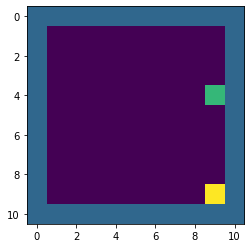

In [118]:
obs = env.reset()
plt.imshow(obs)

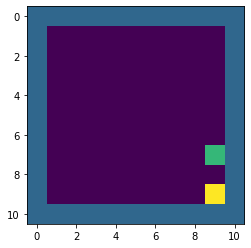

In [123]:
plt.imshow(env.step(0)[0])

In [124]:
obs = env.step(1)
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(1)
sp_img = env.maze.to_rgb()

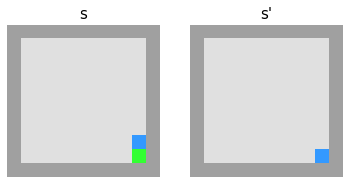

In [125]:
plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_winning_example.png', dpi=300, bbox_inches='tight')

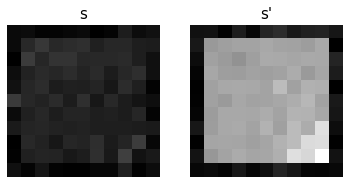

In [126]:
sal = Saliency(rm.tforward)

input = np.array((obs[0], next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = np.abs(sal.attribute(input))
vmin, vmax = attributions.min(), attributions.max()

plt.subplot(1, 2, 1) # Raw Saliency
plt.imshow(attributions.detach()[0, 0, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2) # Raw Saliency
plt.imshow(attributions.detach()[0, 1, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_gradient_winning_example.png', dpi=300, bbox_inches='tight')

In [127]:
rm.tforward(input)

tensor([[1.0014]], grad_fn=<MmBackward>)

In [23]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

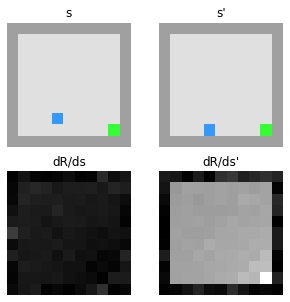

In [233]:
TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

def cm(i):
    if i <= 1:
        return 'viridis'
    else:
        return 'gray'

obs = env.reset()
screenshot = env.render(mode='rgb_array')
imshows = []
imshows.append(axes[0].imshow(screenshot))
imshows.append(axes[1].imshow(screenshot))
imshows.append(axes[2].imshow(obs, cmap='gray'))
imshows.append(axes[3].imshow(obs, cmap='gray'))
axes[0].set_title("s")
axes[1].set_title("s'")
axes[2].set_title("dR/ds")
axes[3].set_title("dR/ds'")

with writer.saving(fig, f"presentation/{env_id}_ss.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        s_img = env.maze.to_rgb()
        action, _states = model.predict(obs, deterministic=False)
        next_obs, reward, done, info = env.step(action)
        sp_img = env.maze.to_rgb()
        
        imshows[0].set_data(s_img)
        imshows[1].set_data(sp_img)
        
        sal = Saliency(rm.tforward)

        input = np.array((obs, next_obs)).astype(np.float32)
        input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = np.abs(sal.attribute(input))

        imshows[2].set_data(attributions.detach()[0, 0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())
        
        imshows[3].set_data(attributions.detach()[0, 1, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()
        
        if done:
            obs = env.reset()
            next_obs = np.zeros((11, 11))
        else:
            obs = next_obs

In [ ]:
plt.figure(figsize=(6.5, 2))
sal = Saliency(rm.tforward)

w = 6

i = 1

while i <= w:
    obs = env.reset()
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    
    plt.subplot(3, w, i)
    screenshot = env.get_image()
    plt.imshow(screenshot)
    plt.axis('off')
    
    plt.subplot(3, w, w+i)
    input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
    input.requires_grad = True
    attributions = sal.attribute(input)
    attributions = np.abs(attributions.detach()[0, ...])
    plt.imshow(attributions, cmap='gray')
    plt.axis('off')
    
    i += 1

plt.savefig(f"mazesaliency/RandomMazeFixedGoalandRandomMazeFixedGoalRewardModel.pdf", dpi=300, bbox_inches='tight')


# Let's do CoinFlipGoal now

In [14]:
env_id = envs[1]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-CoinFlipGoal-v3


In [15]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [16]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v3-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v3-rollout.gif", width=110, height=110)

In [17]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}_ss-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [24]:
N = 12

obs = env.reset()
next_obs = None
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    next_obs, reward, done, info = env.step(action)
    reward_input = np.array((obs, next_obs)).astype(np.float32)
    predicted_rewards.append(float(rm(np.expand_dims(reward_input, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
    else:
        obs = next_obs
print("Predicted: ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: -0.00 +0.00 -0.00 -0.00 -0.01 +0.00 +0.00 +0.01 +0.01 -0.00 -0.00 +0.98 
True     : +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +1.00 


### Okay so this reward model appears to be working correctly

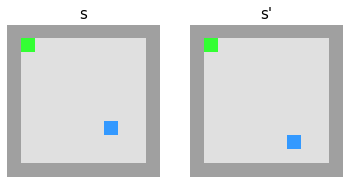

In [25]:
obs = env.reset()
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(action)
sp_img = env.maze.to_rgb()

plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_example.png', dpi=300, bbox_inches='tight')

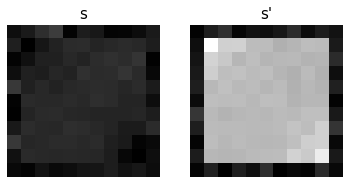

In [152]:
sal = Saliency(rm.tforward)

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = np.abs(sal.attribute(input))
vmin, vmax = attributions.min(), attributions.max()

plt.subplot(1, 2, 1) # Raw Saliency
plt.imshow(attributions.detach()[0, 0, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2) # Raw Saliency
plt.imshow(attributions.detach()[0, 1, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_gradient_example.png', dpi=300, bbox_inches='tight')

In [153]:
rm.tforward(input)

tensor([[-0.0081]], grad_fn=<MmBackward>)

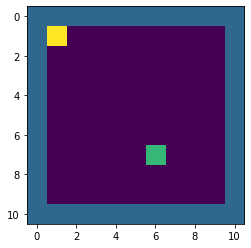

In [156]:
obs = env.reset()
plt.imshow(obs)

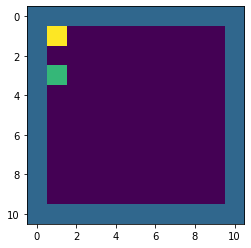

In [165]:
plt.imshow(env.step(0)[0])

In [166]:
obs = env.step(0)
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(0)
sp_img = env.maze.to_rgb()

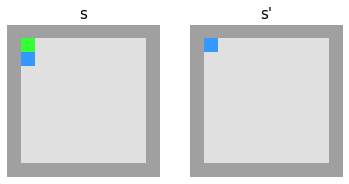

In [167]:
plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_winning_example.png', dpi=300, bbox_inches='tight')

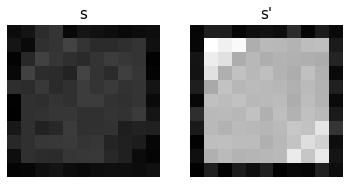

In [168]:
sal = Saliency(rm.tforward)

input = np.array((obs[0], next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = np.abs(sal.attribute(input))
vmin, vmax = attributions.min(), attributions.max()

plt.subplot(1, 2, 1) # Raw Saliency
plt.imshow(attributions.detach()[0, 0, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2) # Raw Saliency
plt.imshow(attributions.detach()[0, 1, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_gradient_winning_example.png', dpi=300, bbox_inches='tight')

In [169]:
rm.tforward(input)

tensor([[0.9750]], grad_fn=<MmBackward>)

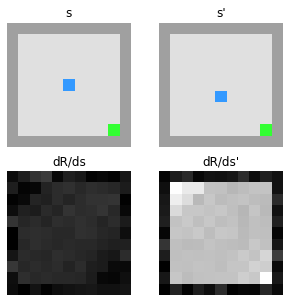

In [215]:
TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

def cm(i):
    if i <= 1:
        return 'viridis'
    else:
        return 'gray'

obs = env.reset()
screenshot = env.render(mode='rgb_array')
imshows = []
imshows.append(axes[0].imshow(screenshot))
imshows.append(axes[1].imshow(screenshot))
imshows.append(axes[2].imshow(obs, cmap='gray'))
imshows.append(axes[3].imshow(obs, cmap='gray'))
axes[0].set_title("s")
axes[1].set_title("s'")
axes[2].set_title("dR/ds")
axes[3].set_title("dR/ds'")

with writer.saving(fig, f"presentation/{env_id}_ss.mp4", dpi=100):
    for i in tqdm(range(TIMESTEPS)):
        s_img = env.maze.to_rgb()
        action, _states = model.predict(obs, deterministic=False)
        next_obs, reward, done, info = env.step(action)
        sp_img = env.maze.to_rgb()
        
        imshows[0].set_data(s_img)
        imshows[1].set_data(sp_img)
        
        sal = Saliency(rm.tforward)

        input = np.array((obs, next_obs)).astype(np.float32)
        input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = np.abs(sal.attribute(input))

        imshows[2].set_data(attributions.detach()[0, 0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())
        
        imshows[3].set_data(attributions.detach()[0, 1, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()
        
        if done:
            obs = env.reset()
            next_obs = np.zeros((11, 11))
        else:
            obs = next_obs

## Let's now investigate failure modes:

### (1) The double-goal failure mode:

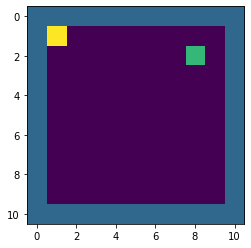

In [42]:
obs = env.reset()
plt.imshow(obs)

In [43]:
env.maze.objects.goal.positions.append([9, 9])

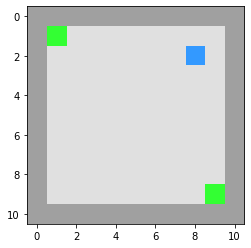

In [44]:
plt.imshow(env.maze.to_rgb())

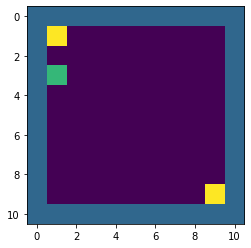

In [54]:
plt.imshow(env.step(2)[0])

In [55]:
obs, _, _, _ = env.step(0)
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(0)
sp_img = env.maze.to_rgb()

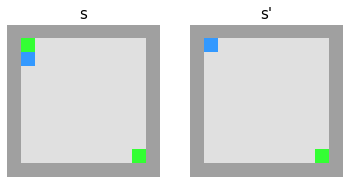

In [56]:
plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_doublegoal_winning_example.png', dpi=300, bbox_inches='tight')

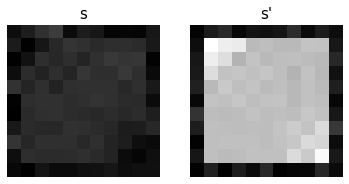

In [57]:
sal = Saliency(rm.tforward)

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = np.abs(sal.attribute(input))
vmin, vmax = attributions.min(), attributions.max()

plt.subplot(1, 2, 1) # Raw Saliency
plt.imshow(attributions.detach()[0, 0, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2) # Raw Saliency
plt.imshow(attributions.detach()[0, 1, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_doublegoal_gradient_winning_example.png', dpi=300, bbox_inches='tight')

In [58]:
rm.tforward(input)

tensor([[0.0041]], grad_fn=<MmBackward>)

### (2) random goal failure mode

In [173]:
env_id = 'EmptyMaze-10x10-RandomGoal-v3'
env = gym.make(env_id)

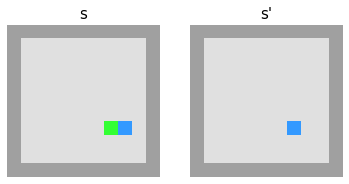

In [174]:
obs = env.reset()
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(action)
sp_img = env.maze.to_rgb()

plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_example.png', dpi=300, bbox_inches='tight')

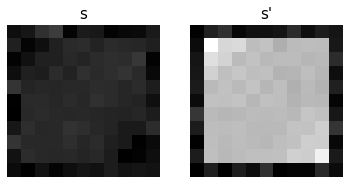

In [68]:
sal = Saliency(rm.tforward)

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
input.requires_grad = True
attributions = np.abs(sal.attribute(input))
vmin, vmax = attributions.min(), attributions.max()

plt.subplot(1, 2, 1) # Raw Saliency
plt.imshow(attributions.detach()[0, 0, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2) # Raw Saliency
plt.imshow(attributions.detach()[0, 1, ...], cmap='gray', vmin=vmin, vmax=vmax)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_gradient_example.png', dpi=300, bbox_inches='tight')

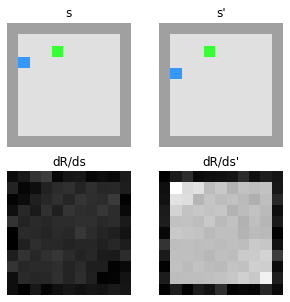

In [308]:
TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flatten()
for ax in axes:
    ax.axis('off')

def cm(i):
    if i <= 1:
        return 'viridis'
    else:
        return 'gray'

obs = env.reset()
screenshot = env.render(mode='rgb_array')
imshows = []
imshows.append(axes[0].imshow(screenshot))
imshows.append(axes[1].imshow(screenshot))
imshows.append(axes[2].imshow(obs, cmap='gray'))
imshows.append(axes[3].imshow(obs, cmap='gray'))
axes[0].set_title("s")
axes[1].set_title("s'")
axes[2].set_title("dR/ds")
axes[3].set_title("dR/ds'")

with writer.saving(fig, f"presentation/{env_id}_ss.mp4", dpi=100):
    n = 0
    for i in tqdm(range(TIMESTEPS)):
        s_img = env.maze.to_rgb()
        action, _states = model.predict(obs, deterministic=False)
        next_obs, reward, done, info = env.step(action)
        sp_img = env.maze.to_rgb()
        
        imshows[0].set_data(s_img)
        imshows[1].set_data(sp_img)
        
        sal = Saliency(rm.tforward)

        input = np.array((obs, next_obs)).astype(np.float32)
        input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
        input.requires_grad = True
        attributions = np.abs(sal.attribute(input))

        imshows[2].set_data(attributions.detach()[0, 0, ...])
        imshows[2].set_clim(attributions.min(), attributions.max())
        
        imshows[3].set_data(attributions.detach()[0, 1, ...])
        imshows[3].set_clim(attributions.min(), attributions.max())
    
        writer.grab_frame()
        
        if done or n == 25: # limit episode lengths to 15 frames (~2 seconds)
            n = 0
            obs = env.reset()
            next_obs = np.zeros((11, 11))
        else:
            obs = next_obs
            n += 1

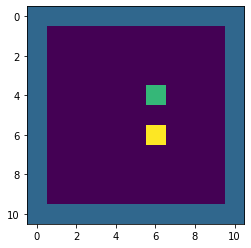

In [79]:
plt.imshow(env.step(1)[0])

In [80]:
obs, _, _, _ = env.step(1)
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(1)
sp_img = env.maze.to_rgb()

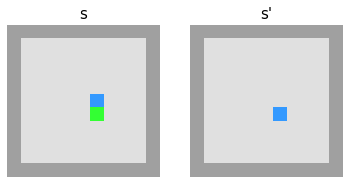

In [81]:
plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_winning_example.png', dpi=300, bbox_inches='tight')

In [82]:
input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
rm.tforward(input)

tensor([[0.6499]], grad_fn=<MmBackward>)

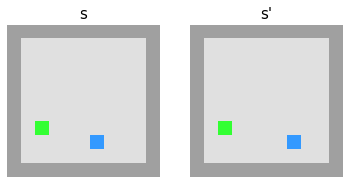

In [182]:
obs = env.reset()
s_img = env.maze.to_rgb()
next_obs, reward, done, info = env.step(3)
sp_img = env.maze.to_rgb()


plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_nonwinning_example.png', dpi=300, bbox_inches='tight')

In [183]:
input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
rm.tforward(input)

tensor([[0.0568]], grad_fn=<MmBackward>)

In [86]:
import random

tensor([[0.6839]], grad_fn=<MmBackward>)


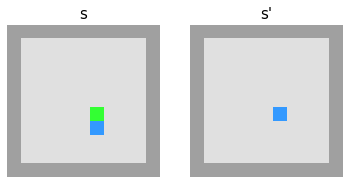

In [87]:
obs = env.reset()
goal_pos = [random.randint(2, 8), random.randint(2, 8)]
env.maze.objects.goal.positions = [goal_pos]
env.maze.objects.agent.positions = [[goal_pos[0] + 1, goal_pos[1]]]
obs = env.maze.to_value()
s_img = env.maze.to_rgb()

env.maze.objects.agent.positions = [goal_pos]
next_obs = env.maze.to_value()
sp_img = env.maze.to_rgb()

plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
print(rm.tforward(input))

plt.savefig(f'presentation/{env_id}_ss_winning_random_example0.png', dpi=300, bbox_inches='tight')

tensor([[0.6146]], grad_fn=<MmBackward>)


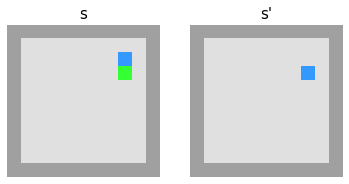

In [93]:
obs = env.reset()
goal_pos = [random.randint(2, 8), random.randint(2, 8)]
env.maze.objects.goal.positions = [goal_pos]
env.maze.objects.agent.positions = [[goal_pos[0] - 1, goal_pos[1]]]
obs = env.maze.to_value()
s_img = env.maze.to_rgb()

env.maze.objects.agent.positions = [goal_pos]
next_obs = env.maze.to_value()
sp_img = env.maze.to_rgb()

plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
print(rm.tforward(input))

plt.savefig(f'presentation/{env_id}_ss_winning_random_example1.png', dpi=300, bbox_inches='tight')

tensor([[0.0811]], grad_fn=<MmBackward>)


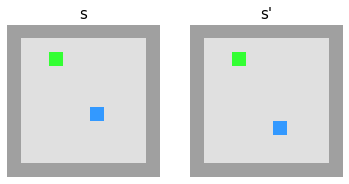

In [94]:
obs = env.reset()
goal_pos = [random.randint(2, 8), random.randint(2, 8)]
agent_pos = [random.randint(2, 8), random.randint(2, 8)]
env.maze.objects.goal.positions = [goal_pos]
env.maze.objects.agent.positions = [agent_pos]
obs = env.maze.to_value()
s_img = env.maze.to_rgb()

env.maze.objects.agent.positions = [[agent_pos[0]+1, agent_pos[1]]]
next_obs = env.maze.to_value()
sp_img = env.maze.to_rgb()

plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
print(rm.tforward(input))

plt.savefig(f'presentation/{env_id}_ss_notwinning_random_example0.png', dpi=300, bbox_inches='tight')

tensor([[0.0527]], grad_fn=<MmBackward>)


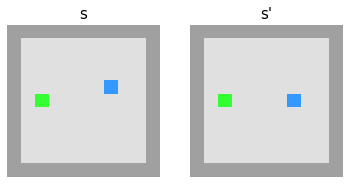

In [97]:
obs = env.reset()
goal_pos = [random.randint(2, 8), random.randint(2, 8)]
agent_pos = [random.randint(2, 8), random.randint(2, 8)]
env.maze.objects.goal.positions = [goal_pos]
env.maze.objects.agent.positions = [agent_pos]
obs = env.maze.to_value()
s_img = env.maze.to_rgb()

env.maze.objects.agent.positions = [[agent_pos[0]+1, agent_pos[1]]]
next_obs = env.maze.to_value()
sp_img = env.maze.to_rgb()

plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
print(rm.tforward(input))

plt.savefig(f'presentation/{env_id}_ss_notwinning_random_example1.png', dpi=300, bbox_inches='tight')

In [98]:
obs = env.reset()
goal_pos = [random.randint(2, 8), random.randint(2, 8)]
agent_pos = [random.randint(2, 8), random.randint(2, 8)]
env.maze.objects.goal.positions = [goal_pos]
env.maze.objects.agent.positions = [agent_pos]
obs = env.maze.to_value()
s_img = env.maze.to_rgb()

env.maze.objects.agent.positions = [[agent_pos[0]+1, agent_pos[1]]]
next_obs = env.maze.to_value()
sp_img = env.maze.to_rgb()

In [99]:
for _ in range(15):
    goal_pos = [random.randint(2, 8), random.randint(2, 8)]
    env.maze.objects.goal.positions.append(goal_pos)

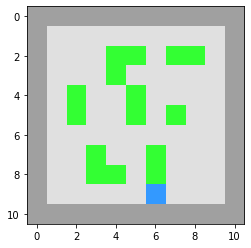

In [100]:
sp_img = env.maze.to_rgb()
plt.imshow(sp_img)

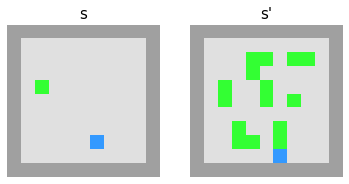

In [101]:
plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_notwinning_random_manygoals.png', dpi=300, bbox_inches='tight')

In [102]:
next_obs = env.maze.to_value()
input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
print(rm.tforward(input))

tensor([[-1.6130]], grad_fn=<MmBackward>)


## (3) no goal in either s or s' failure

In [270]:
env.reset()
obs = env.maze.to_value()
s_img = env.maze.to_rgb()

action, _states = model.predict(obs, deterministic=False)
next_obs, reward, done, info = env.step(action)
sp_img = env.maze.to_rgb()

(-0.5, 10.5, 10.5, -0.5)

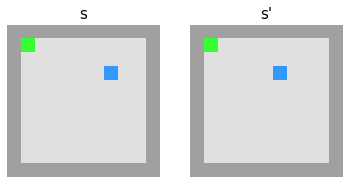

In [271]:
plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

In [272]:
obs

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [273]:
obs[1, 1] = 0
obs

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [274]:
next_obs[1, 1] = 0
next_obs

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [275]:
s_img[1, 1] = s_img[2, 2]
sp_img[1, 1] = sp_img[2, 2]

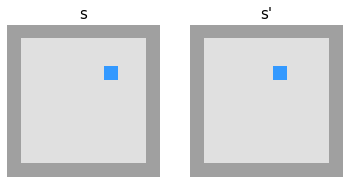

In [278]:
plt.subplot(1, 2, 1)
plt.imshow(s_img)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sp_img)
plt.title("s'", fontsize=15)
plt.axis('off')

plt.savefig(f'presentation/{env_id}_ss_nogoalwhatsoever.png', dpi=300, bbox_inches='tight')


(-0.5, 10.5, 10.5, -0.5)

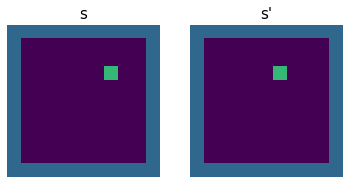

In [280]:
plt.subplot(1, 2, 1)
plt.imshow(obs, vmin=0, vmax=3)
plt.title('s', fontsize=15)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(next_obs, vmin=0, vmax=3)
plt.title("s'", fontsize=15)
plt.axis('off')

In [281]:
input = np.array((obs, next_obs)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
print(rm.tforward(input))

tensor([[0.9682]], grad_fn=<MmBackward>)


# Figures for the paper

In [70]:
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [71]:
plt.figure(figsize=(5.5, 2.5))

sal = Saliency(rm.tforward)
w = 6
i = 1

while i <= w:
    obs = env.reset()
    action, _states = model.predict(obs, deterministic=False)
    next_obs, reward, done, info = env.step(action)
    if i == w:
        obs = env.reset()
        goal_pos = env.maze.objects.goal.positions[0]
        if goal_pos == [1, 1]:
            agent_pos = [2, 1]
        else:
            agent_pos = [8, 9]
        env.maze.objects.agent.positions[0] = agent_pos
        obs = env.maze.to_value()
        env.maze.objects.agent.positions[0] = goal_pos
        next_obs = env.maze.to_value()
        
    
    ax = plt.subplot(3, w, i)
    screenshot = env.maze.to_rgb()
    ax.imshow(screenshot)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
#     plt.axis('off')
    if i == 1:
        ax.set_ylabel("s'", rotation=45)
    
    input = np.array((obs, next_obs)).astype(np.float32)
    input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
    input.requires_grad = True
    attributions = sal.attribute(input)
    attributions = np.abs(attributions.detach()[0, ...])
    
    ax = plt.subplot(3, w, w+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(attributions[0, ...], cmap='gray', vmin=attributions.min(), vmax=attributions.max())
    if i == 1:
        ax.set_ylabel("\frac{dR}{ds}", rotation=45)
    
    
    ax = plt.subplot(3, w, 2*w + i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(attributions[1, ...], cmap='gray', vmin=attributions.min(), vmax=attributions.max())
    
    
    i += 1

# plt.savefig(f"mazesaliency/RandomMazeFixedGoalandRandomMazeFixedGoalRewardModel.pdf", dpi=300, bbox_inches='tight')


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 396x180 with 18 Axes>

# Let's look at a RandomMaze environment now.

In [11]:
env_id = 'RandomMaze-7x7-CoinFlipGoal-v3'
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

RandomMaze-7x7-CoinFlipGoal-v3


In [12]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [13]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v3-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v3-rollout.gif", width=110, height=110)

In [235]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}_ss-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [226]:
N = 12

obs = env.reset()
next_obs = None
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    next_obs, reward, done, info = env.step(action)
    reward_input = np.array((obs, next_obs)).astype(np.float32)
    predicted_rewards.append(float(rm(np.expand_dims(reward_input, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
    else:
        obs = next_obs
print("Predicted: ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: -0.00 +0.00 -0.00 -0.00 -0.01 +0.00 +0.00 +0.01 +0.01 -0.00 -0.00 +0.98 
True     : +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +1.00 


# Scratch space for creating extra visualizations:

In [184]:
env_id = 'EmptyMaze-10x10-FixedGoal-v3'
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-FixedGoal-v3


In [185]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [186]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v3-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v3-rollout.gif", width=110, height=110)

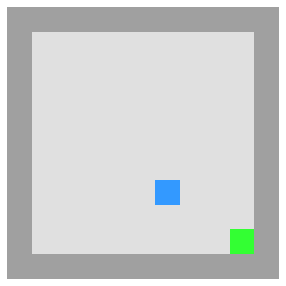

In [131]:
TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.axis('off')

obs = env.reset()
screenshot = env.maze.to_rgb()
imshow = ax.imshow(screenshot)

with writer.saving(fig, f"presentation/{env_id}_rollouts.mp4", dpi=100):
    n = 0
    for i in tqdm(range(TIMESTEPS)):
        s_img = env.maze.to_rgb()
        action, _states = model.predict(obs, deterministic=False)
        next_obs, reward, done, info = env.step(action)
        sp_img = env.maze.to_rgb()
        
        imshow.set_data(s_img)
    
        writer.grab_frame()
        
        if done or n == 30: # limit episode lengths to 15 frames (~2 seconds)
            n = 0
            obs = env.reset()
            next_obs = np.zeros((11, 11))
        else:
            obs = next_obs
            n += 1

In [132]:
env_id = 'EmptyMaze-10x10-CoinFlipGoal-v3'
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-CoinFlipGoal-v3


In [133]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [134]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v3-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v3-rollout.gif", width=110, height=110)

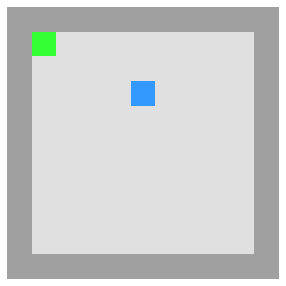

In [135]:
TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"{env_id} reward saliency", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.axis('off')

obs = env.reset()
screenshot = env.maze.to_rgb()
imshow = ax.imshow(screenshot)

with writer.saving(fig, f"presentation/{env_id}_rollouts.mp4", dpi=100):
    n = 0
    for i in tqdm(range(TIMESTEPS)):
        s_img = env.maze.to_rgb()
        action, _states = model.predict(obs, deterministic=False)
        next_obs, reward, done, info = env.step(action)
        sp_img = env.maze.to_rgb()
        
        imshow.set_data(s_img)
    
        writer.grab_frame()
        
        if done or n == 30: # limit episode lengths to 15 frames (~2 seconds)
            n = 0
            obs = env.reset()
            next_obs = np.zeros((11, 11))
        else:
            obs = next_obs
            n += 1

In [187]:
env_id = 'EmptyMaze-10x10-RandomGoal-v3'
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-RandomGoal-v3


In [189]:
env = gym.make(env_id)

(-0.5, 10.5, 10.5, -0.5)

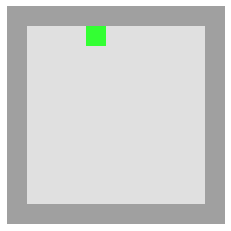

In [204]:
obs = env.reset()
env.maze.objects.goal.positions = [[1, 4]]
env.maze.objects.agent.rgb = env.maze.objects.free.rgb
plt.imshow(env.maze.to_rgb())
plt.axis('off')

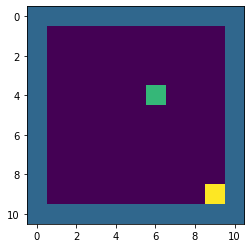

In [108]:
s = env.reset()
sp = np.copy(s)
plt.imshow(s)

In [109]:
env.maze.objects.agent
apos = env.maze.objects.agent.positions[0]
gpos = env.maze.objects.goal.positions[0]
ppos = [1, 1] if gpos == [9, 9] else [9, 9]

In [110]:
sp

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [111]:
sp[apos[0], apos[1]] = 0

In [112]:
sp

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [113]:
sp[ppos[0], ppos[1]] = 2
sp

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [116]:
input = np.array((s, sp)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
rm.tforward(input)

tensor([[-0.1015]], grad_fn=<MmBackward>)

### okay so just inserting an agent in the opposite goal state doesn't confuse the reward model -- since it can see the goal object still in the opposite corner. 

### what happens if we remove the goal object from s'?

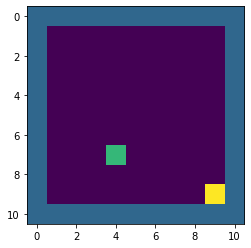

In [117]:
s = env.reset()
sp = np.copy(s)
plt.imshow(s)

In [118]:
env.maze.objects.agent
apos = env.maze.objects.agent.positions[0]
gpos = env.maze.objects.goal.positions[0]
ppos = [1, 1] if gpos == [9, 9] else [9, 9]

In [119]:
sp

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [120]:
sp[apos[0], apos[1]] = 0

In [121]:
sp

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [124]:
sp[gpos[0], gpos[1]] = 0
sp

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [125]:
sp[ppos[0], ppos[1]] = 2
sp

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

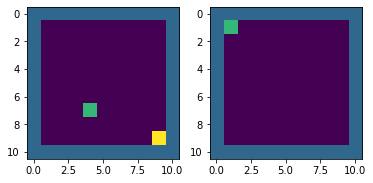

In [130]:
plt.subplot(1, 2, 1)
plt.imshow(s, vmin=0, vmax=3)
plt.subplot(1, 2, 2)
plt.imshow(sp, vmin=0, vmax=3)

In [131]:
input = np.array((s, sp)).astype(np.float32)
input = th.tensor(np.expand_dims(input, axis=0)).to('cpu').to(dtype)
rm.tforward(input)

tensor([[0.6444]], grad_fn=<MmBackward>)

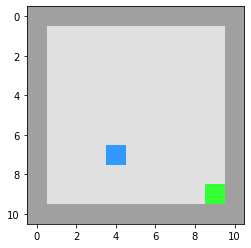

In [134]:
plt.imshow(env.maze.to_rgb())